In [1]:
import numpy as np 
import pandas as pd 
import os
print(os.listdir("../input"))

['train', 'test', 'train.csv', 'sample_submission.csv']


In [2]:
from keras.models import Sequential
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16

Using TensorFlow backend.


In [3]:
train_df = pd.read_csv("../input/train.csv")
train_df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [4]:
train_df = pd.read_csv("../input/train.csv")
train_df["has_cactus"] = train_df["has_cactus"].map(lambda x:str(x))

train_datagen = ImageDataGenerator(rescale=1./255,
                                 validation_split=0.1,
                                 rotation_range=40,
                                 shear_range=0.2,
                                 width_shift_range=0.2,
                                 height_shift_range=0.2,
                                 horizontal_flip=True,
                                 zoom_range=0.2,
                                 fill_mode='nearest')

train_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                    directory="../input/train/train",
                                                    x_col="id",
                                                    y_col="has_cactus",
                                                    batch_size=32,
                                                    shuffle=True,
                                                    class_mode="binary",
                                                    target_size=(32,32),
                                                    subset="training")

validation_generator = train_datagen.flow_from_dataframe(dataframe=train_df,
                                                         directory="../input/train/train",
                                                         x_col="id",
                                                         y_col="has_cactus",
                                                         batch_size=32,
                                                         shuffle=True,
                                                         class_mode="binary",
                                                         target_size=(32,32),
                                                         subset="validation")

Found 15750 images belonging to 2 classes.
Found 1750 images belonging to 2 classes.


In [5]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(32,32,3))

conv_base.summary()

Instructions for updating:
Colocations handled automatically by placer.
58892288/58889256 [==============================] - 1s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_____

In [6]:
conv_base.trainable = False
conv_base.trainable

False

In [7]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 14,846,273
Trainable params: 131,585
Non-trainable params: 14,714,688
_________________________________________________________________


In [8]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())

model.add(layers.Dense(470, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.5))

model.add(layers.Dense(128, activation='tanh'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 1, 1, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 470)               241110    
_________________________________________________________________
batch_normalization_1 (Batch (None, 470)               1880      
_________________________________________________________________
dropout_1 (Dropout)          (None, 470)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               60288     
___________________________

In [9]:
model.compile(loss='binary_crossentropy',
              #optimizer=optimizers.RMSprop(lr=1e-4),
              optimizer=optimizers.Adam(lr=1e-4),
              metrics=['acc'])

In [10]:
history = model.fit_generator(generator=train_generator,
                              validation_data=validation_generator,
                              validation_steps=int(train_df.shape[0]*0.1/32),
                              steps_per_epoch=int(train_df.shape[0]/32),
                              epochs=200,
                             )

Instructions for updating:
Use tf.cast instead.
Epoch 1/200
546/546 [==============================] - 47s 87ms/step - loss: 0.2975 - acc: 0.8716 - val_loss: 0.1482 - val_acc: 0.9381
Epoch 2/200
546/546 [==============================] - 34s 63ms/step - loss: 0.1741 - acc: 0.9315 - val_loss: 0.1375 - val_acc: 0.9430
Epoch 3/200
546/546 [==============================] - 36s 66ms/step - loss: 0.1611 - acc: 0.9345 - val_loss: 0.1328 - val_acc: 0.9540
Epoch 4/200
546/546 [==============================] - 34s 62ms/step - loss: 0.1594 - acc: 0.9353 - val_loss: 0.1242 - val_acc: 0.9529
Epoch 5/200
546/546 [==============================] - 34s 63ms/step - loss: 0.1530 - acc: 0.9390 - val_loss: 0.1230 - val_acc: 0.9563
Epoch 6/200
546/546 [==============================] - 36s 66ms/step - loss: 0.1422 - acc: 0.9420 - val_loss: 0.1249 - val_acc: 0.9523
Epoch 7/200
546/546 [==============================] - 35s 63ms/step - loss: 0.1407 - acc: 0.9448 - val_loss: 0.1165 - val_acc: 0.9540
Epoch 8

In [11]:
model.save('VGG16_V7.h5')

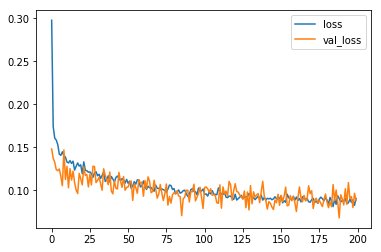

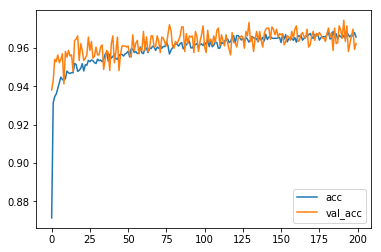

In [12]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()
history_df[['acc', 'val_acc']].plot()

In [13]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(directory=r"../input/test/",
                                                  target_size=(32,32),
                                                  batch_size=1,
                                                  class_mode=None,
                                                  shuffle=False,
                                                  seed=42)
nb_samples = len(test_generator.filenames)

Found 4000 images belonging to 1 classes.


In [14]:
test_generator.reset()
test_predictions = model.predict_generator(test_generator,verbose=1,steps=nb_samples)

4000/4000 [==============================] - 37s 9ms/step


In [15]:
submission = pd.DataFrame({'id':[x.split('test/')[1] for x in test_generator.filenames],
                           'has_cactus':[x[0]for x in test_predictions]})
submission.head()

,id,has_cactus
0,000940378805c44108d287872b2f04ce.jpg,0.990873
1,0017242f54ececa4512b4d7937d1e21e.jpg,0.999975
2,001ee6d8564003107853118ab87df407.jpg,0.004650
3,002e175c3c1e060769475f52182583d0.jpg,0.001176
4,0036e44a7e8f7218e9bc7bf8137e4943.jpg,0.999869


In [16]:
submission.to_csv('submission_VGG16_7.csv',index=False)